In [1]:
import numpy as np
import os
import glob
import torch
from pathlib import Path
from PIL import Image

In [4]:
temp_root = 'E:/repos/StockChartCNN/inputs/raw/crypto/images/btcusd/candle/15_minute/'
dir = Path(temp_root)

In [5]:
image_count = sum([1 for _ in os.listdir(dir)])
image_count

10200

In [6]:
image_filenames = os.listdir(dir)

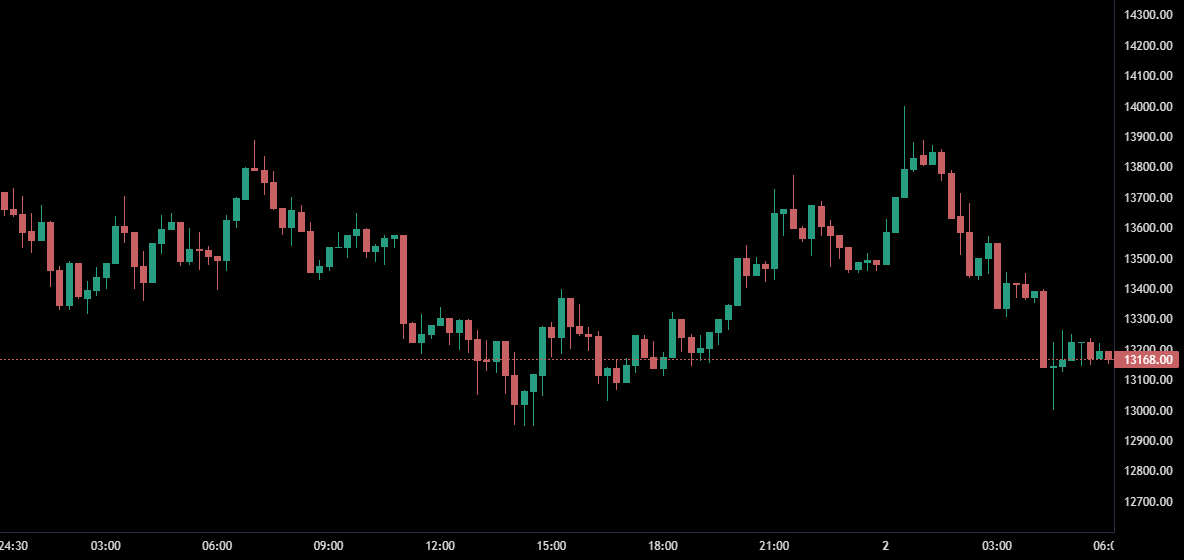

In [7]:
sample_file = temp_root + image_filenames[0]
image = Image.open(sample_file)
image

In [8]:
# image size
width, height = image.size

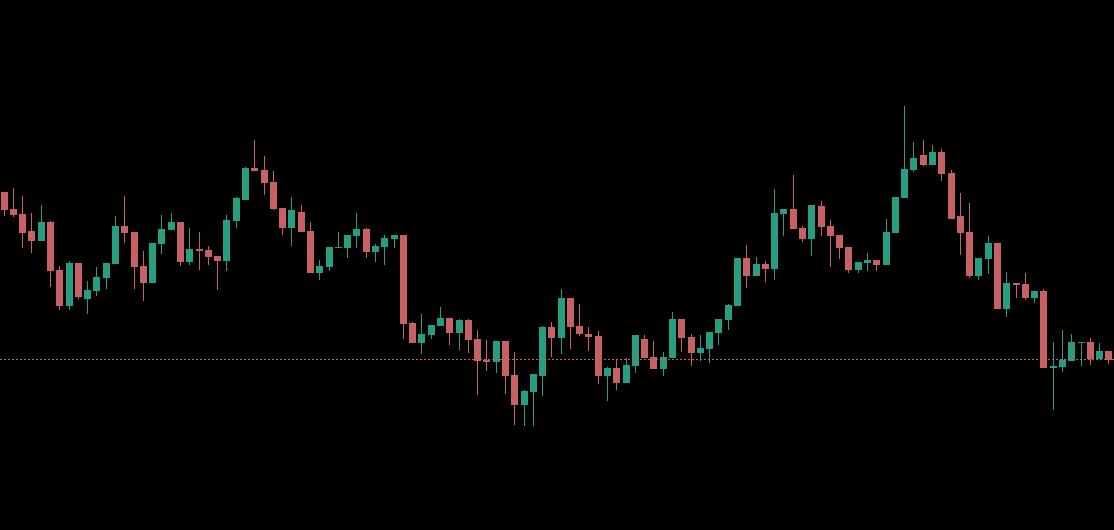

In [9]:
# sample to find right coordinates
x1 = 0
y1 = 0
x2 = width - 70
y2 = height - 30
box = (x1, y1, x2, y2)
image2 = image.crop(box)
image2

In [12]:
tickers = ['btcusd','ethusd','solusd']
bartimes = ['5_minute', '15_minute']

# image size
width, height = image.size

# box coordinates
x1, y1, x2, y2 = 0, 0, width - 70, height - 30

# crop box 
box = (x1, y1, x2, y2)

# loop through each ticker and bartime
for ticker in tickers:
    for bartime in bartimes:
        # original file root
        root = f'E:/repos/StockChartCNN/inputs/raw/crypto/images/{ticker}/candle/{bartime}/'
        out_root = f'E:/repos/StockChartCNN/inputs/clean/crypto/images/{ticker}/candle/{bartime}/y_train/'
        # loop through each file in the directory
        for file in os.listdir(root):
            #change file ending to jpg
            jpg_file = file.replace('.png','.jpg')
            
            # create the paths
            orig_path = root + file
            out_path = out_root + jpg_file
            
            # open and crop image
            image = Image.open(orig_path)
            image = image.crop(box)

            # check that filepath exist, else make one
            out_path = Path(out_path)
            out_path.parent.mkdir(parents=True, exist_ok=True)

            # convert the image to a jpg and save it
            image.convert('RGB').save(out_path,"JPEG")

In [71]:
# perform data cutout
def apply_mask_v1(image, size=0, n_squares=1):
    height, width, channels = image.shape
    y1, x2, y2,  = 0, width, height # this stays the same
    new_image = image
    for _ in range(n_squares):
        # change x randomly
        # at minimum masks 10% of image, max 33%
        x = np.random.randint(width // 10, width // 3)
        x1 = width - x

        new_image[y1:y2,x1:x2,:] = 0
    return new_image


In [72]:
def apply_mask_v2(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

In [73]:
def apply_mask_seq(image, size=0, n_squares=0):
    h, w, channels = image.shape
    y1, x2, y2,  = 0, width, height # this stays the same
    new_image = image
    # set the range (20%)
    x1 = width - int(width // 4)
    # mask the area
    new_image[y1:y2,x1:x2,:] = 0
    return new_image

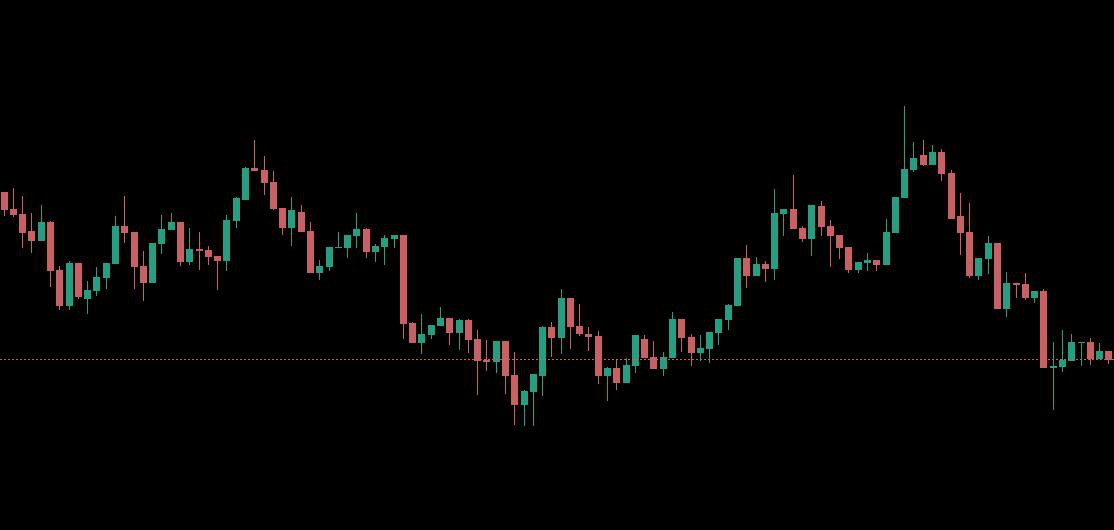

In [15]:
temp_root = 'E:/repos/StockChartCNN/inputs/clean/crypto/images/btcusd/candle/15_minute/y_train/'
dir = Path(temp_root)
image_filenames = os.listdir(dir)

# get the image
sample_file = temp_root + image_filenames[0]
sample_image = Image.open(sample_file)

# show the image
sample_image

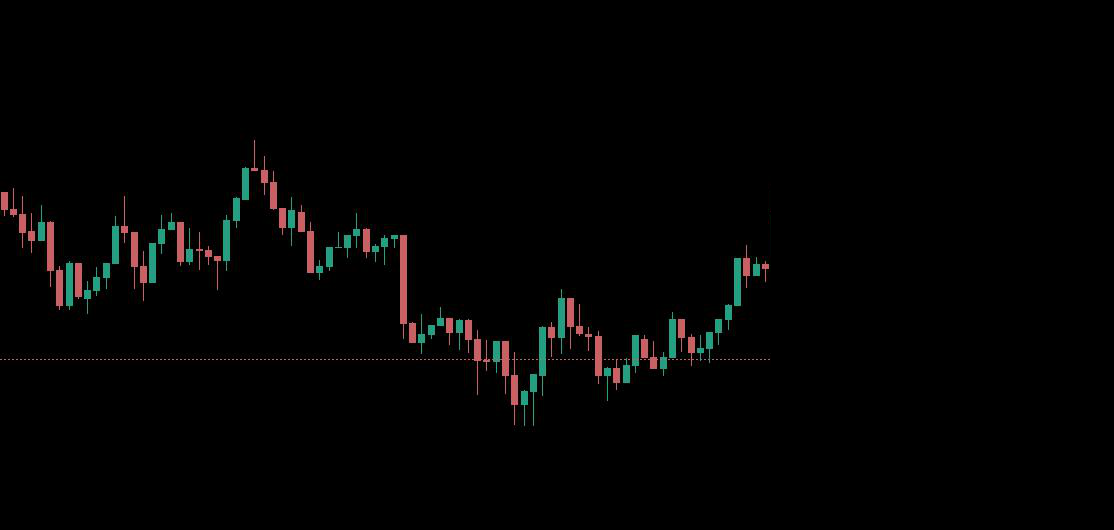

In [61]:
# display v1 mask
new_sample = apply_mask_v1(np.array(sample_image), size=0, n_squares=1)
image = Image.fromarray(new_sample)
image

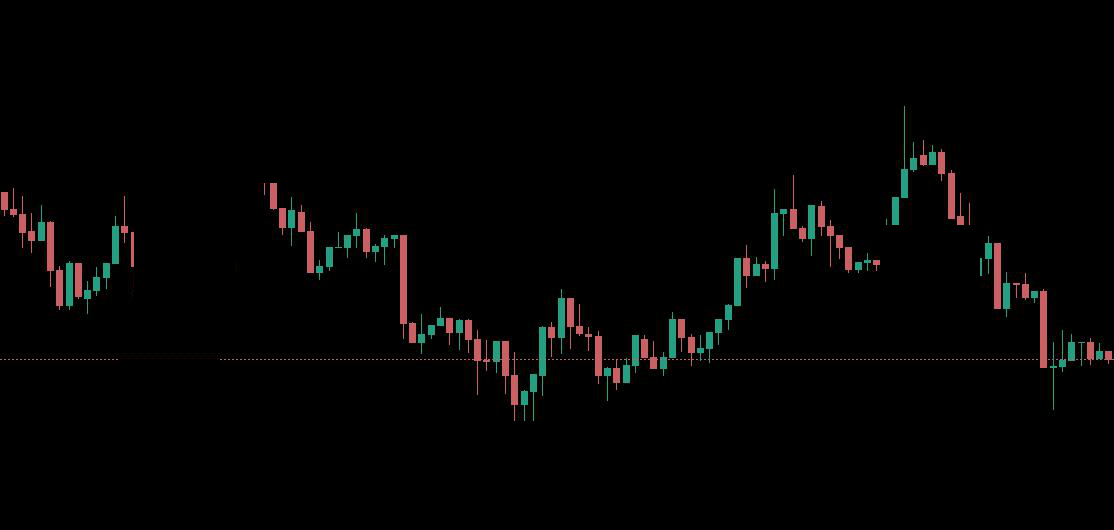

In [28]:
# display v2 mask
new_sample = apply_mask_v2(np.array(sample_image), size=100, n_squares=20)
image = Image.fromarray(new_sample)
image

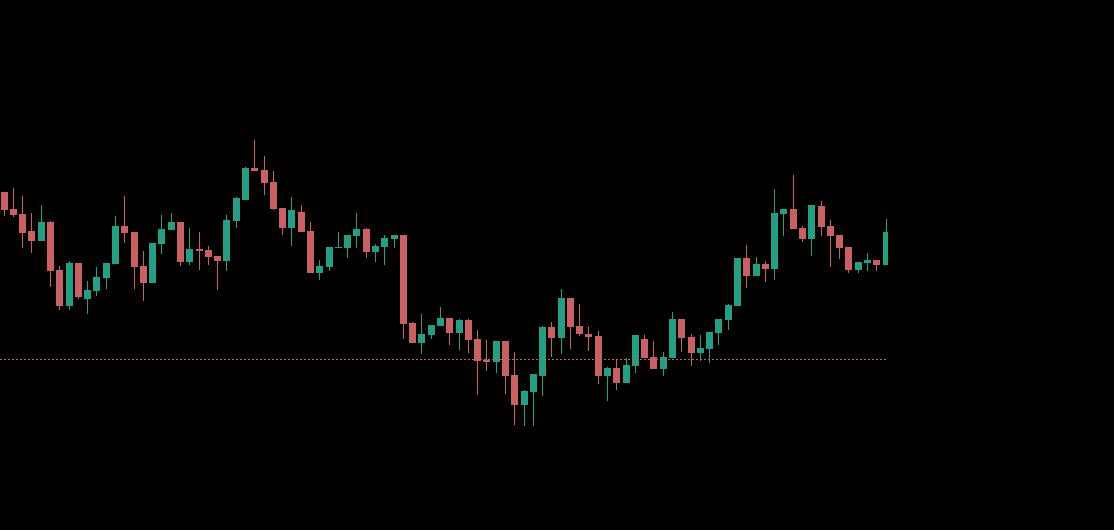

In [67]:
# display sequential mask
new_sample = apply_mask_sequential(np.array(sample_image), size=0, n_squares=0)
image = Image.fromarray(new_sample)
image

In [74]:
def image_creator(image, root, folder, file, size, n_squares, mask):
    # assemble the path
    path = root + folder + file
    # create the path
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    # apply the mask and save the image
    image_new = mask(np.array(image), size=size, n_squares=n_squares)
    image_new = Image.fromarray(image_new)
    image_new.save(path)

In [75]:
tickers = ['btcusd','ethusd','solusd']
bartimes = ['5_minute', '15_minute']

# mask presets
size = 100
n_squares = 20

# loop through each ticker and bartime
for ticker in tickers:
    for bartime in bartimes:
        # original file root
        root = f'E:/repos/StockChartCNN/inputs/clean/crypto/images/{ticker}/candle/{bartime}/y_train/'
        out_root = f'E:/repos/StockChartCNN/inputs/clean/crypto/images/{ticker}/candle/{bartime}/x_train/'
        # loop through each file in the directory
        for file in os.listdir(root):
            # create the paths
            orig_path = root + file

            # open image
            image = Image.open(orig_path)

            # apply the v1 mask and save the image
            image_creator(image, out_root, 'v1/', file, 0, 1, apply_mask_v1)
            # apply the v2 mask and save the image
            image_creator(image, out_root, 'v2/', file, size, n_squares, apply_mask_v2)
            # apply the seq mask and save the image
            image_creator(image, out_root, 'seq/', file, 0, 0, apply_mask_seq)
            